# <u><center>Step 1 - Connect to the database<center></u>

### 1.1 Create the connection & cursor objects, using psycopg2

In [9]:
# Psychopg2 is a library that allows you to interact w/ Postgres database using Python.
import psycopg2 

# Instantiate the connection object
conn = psycopg2.connect(
    database="demo", 
    user="analyst", 
    password="analysttakehome", # Credentials provided by PostgresPro, a learning resource
    host="35.184.230.196", 
    port=5432)

# Create the cursor object. Allows Python to run SQL commands on the DB session that the cursor is bound to. 
cur = conn.cursor()

### 1.2 Remove jupyter notebook warnings (for stylistic purposes)

In [10]:
import warnings 
warnings.filterwarnings('ignore')

### 1.3 Sanity Check - List the tables present in the database

In [11]:
cur.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
# pg_class  --  built in structure that postgres uses to catalog tables in a database
# relkind='r'  --  checks that the table is of type 'r', or 'ordinary table'
# relname !~ '^(pg_|sql_)'  --  regular expression to check that the table name does not contain 'pg' or 'sql'

print('List of tables within database : \n')
for i,j in enumerate(cur.fetchall()):
    print(i+1,'bookings.'+j[0])

List of tables within database : 

1 bookings.ticket_flights
2 bookings.boarding_passes
3 bookings.aircrafts_data
4 bookings.flights
5 bookings.airports_data
6 bookings.seats
7 bookings.tickets
8 bookings.bookings


<br><br><br>

<br><br><br>

# <u><center>Step 2 - Exploratory Data Analysis<center></u>

### 2.0 Load the necessary libraries

In [12]:
# Pandas is a library used for manipulating data. I am using convert SQL query results into dataframes
import pandas as pd 

# Matplotlib is used for graphing
import matplotlib.pyplot as plt

### 2.1 Show me which dates are the busiest for flying.


In [13]:
query = '''
select 
    date(scheduled_arrival) date,
    count(ticket_no) total_passengers
from
    bookings.ticket_flights tf join bookings.flights f
    on tf.flight_id = f.flight_id
group by
    date '''
busiest = pd.read_sql_query(query, con=conn)
busiest

,date,total_passengers
0,2017-08-24,22806
1,2017-09-06,9711
2,2017-08-26,22751
3,2017-09-15,16
4,2017-09-11,4036
...,...,...
57,2017-08-17,22310
58,2017-08-27,22622
59,2017-08-11,21249
60,2017-07-22,12988


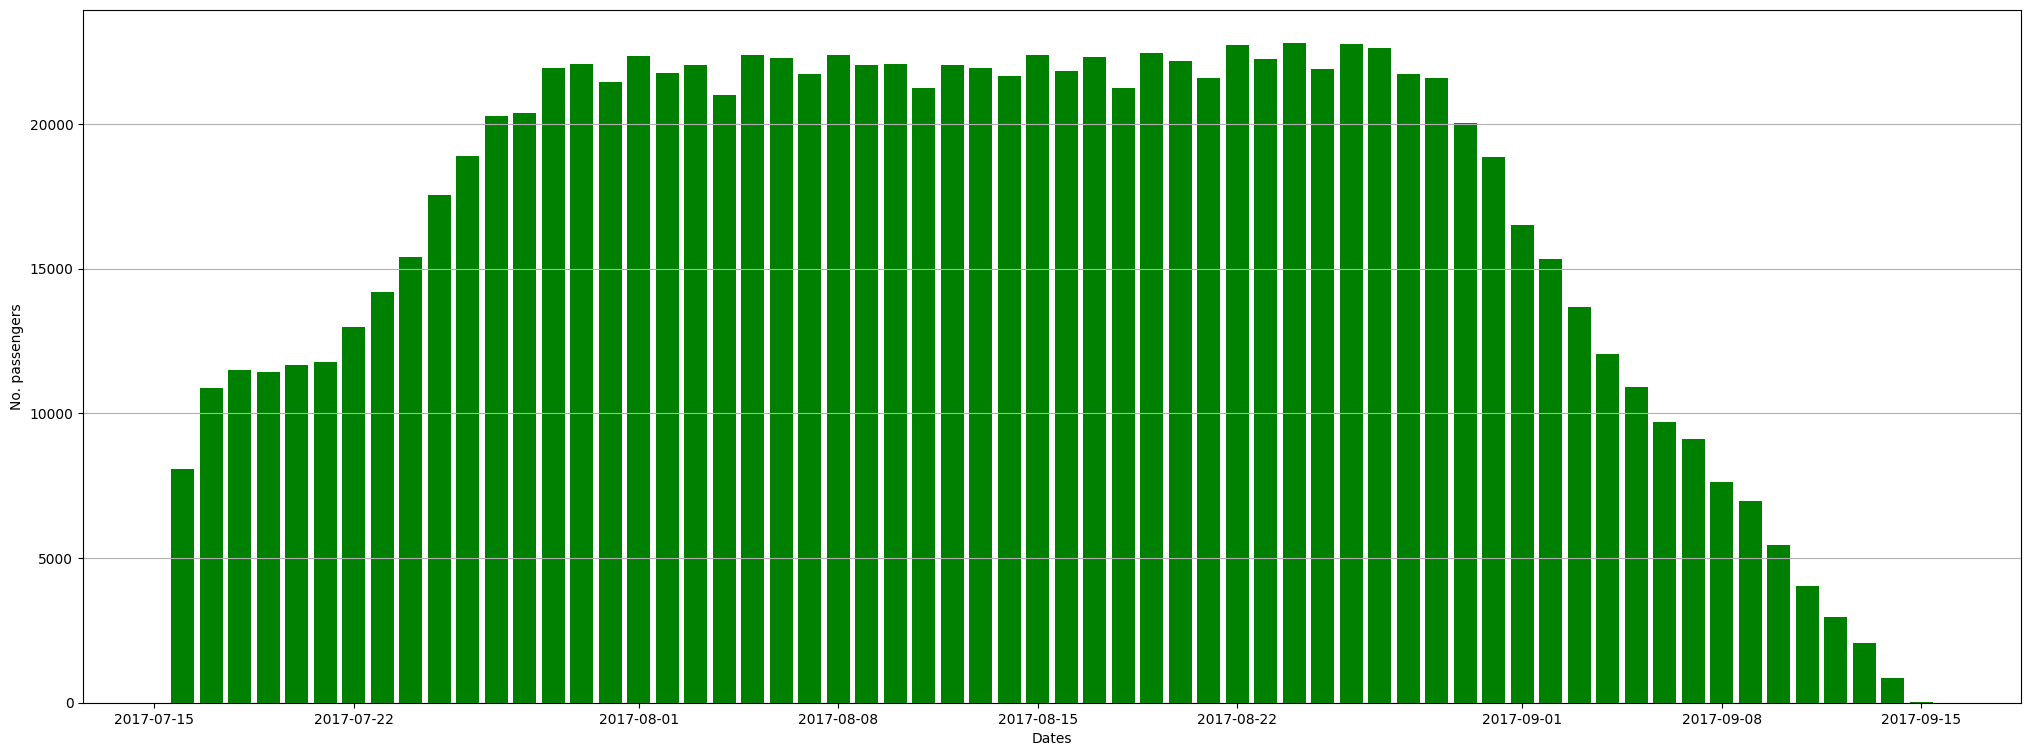

In [14]:
fig = plt.figure(figsize = (25, 9))
plt.bar(
    busiest['date'], # X-values
    busiest['total_passengers'], # Y-values
    color ='green',
        width = 0.8)

plt.grid(axis='y')
plt.xlabel("Dates")
plt.ylabel("No. passengers")
plt.show()

### 2.2 Show me which flight routes are the busiest

In [15]:
# Create the dataframe containing number of passengers per flight route
query = '''
select 
    f.flight_no,
    f.departure_airport,
    f.arrival_airport,
    count(tf.ticket_no) num_passengers
from 
    bookings.ticket_flights tf join bookings.flights f
    on tf.flight_id = f.flight_id
group by 
    f.flight_no,
    f.departure_airport,
    f.arrival_airport
'''
routes = pd.read_sql_query(query, con=conn)
routes

# This is helpful I guess, but I would like to know what airports these codes actually correspond to

,flight_no,departure_airport,arrival_airport,num_passengers
0,PG0465,RTW,ULY,398
1,PG0278,OVB,SVO,12837
2,PG0470,SVO,LED,8245
3,PG0616,CEE,NOZ,108
4,PG0448,VKO,STW,415
...,...,...,...,...
478,PG0678,MCX,SVO,5563
479,PG0411,KLF,LED,304
480,PG0474,LED,SVO,4197
481,PG0452,SVO,BAX,951


##### Data Cleaning

In [16]:
# Get airport data from the bookings.airports_data table
query = 'select * from bookings.airports_data'
location_data = pd.read_sql_query(query, con=conn)

# Create a dictionary that maps airport_code to airport_name
airport = [x['en'] for x in location_data['airport_name']]
airportdict = dict(zip(location_data['airport_code'],airport))

# Create a dictionary that maps airport_code to city
city = [x['en'] for x in location_data['city']]
citydict = dict(zip(location_data['airport_code'],city))

# Add 4 columns to the previous 'routes' dataframe
routes['Departure Airport'] = [airportdict[x] for x in routes['departure_airport']]
routes['Arrival Airport'] = [airportdict[x] for x in routes['arrival_airport']]
routes['Departure City'] = [citydict[x] for x in routes['departure_airport']]
routes['Arrival City'] = [citydict[x] for x in routes['arrival_airport']]

#drop the columns containing the airport codes
routes.drop(['departure_airport', 'arrival_airport'], axis=1) 

#reorder the dataframe
routes = routes[['flight_no','Departure Airport','Arrival Airport','Departure City','Arrival City', 'num_passengers']]

In [86]:
# Show me the 20 most popular flight routes 
top20 = routes.sort_values('num_passengers',ascending=False).head(20)
top20

,flight_no,Departure Airport,Arrival Airport,Departure City,Arrival City,num_passengers
400,PG0222,Domodedovo International Airport,Tolmachevo Airport,Moscow,Novosibirsk,15903
64,PG0225,Sheremetyevo International Airport,Koltsovo Airport,Moscow,Yekaterinburg,15879
251,PG0226,Koltsovo Airport,Sheremetyevo International Airport,Yekaterinburg,Moscow,15433
218,PG0223,Tolmachevo Airport,Domodedovo International Airport,Novosibirsk,Moscow,15402
235,PG0224,Sheremetyevo International Airport,Sochi International Airport,Moscow,Sochi,15155
438,PG0013,Sochi International Airport,Sheremetyevo International Airport,Sochi,Moscow,14661
60,PG0277,Sheremetyevo International Airport,Tolmachevo Airport,Moscow,Novosibirsk,13160
471,PG0412,Vnukovo International Airport,Bolshoye Savino Airport,Moscow,Perm,13070
248,PG0413,Bolshoye Savino Airport,Vnukovo International Airport,Perm,Moscow,12876
1,PG0278,Tolmachevo Airport,Sheremetyevo International Airport,Novosibirsk,Moscow,12837


### 2.3 Show me which airplane types are carrying the most people

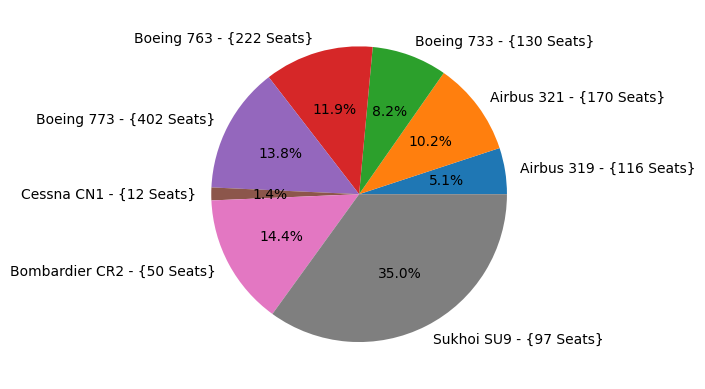

In [147]:
query = '''
select 
    aircraft_code,
    count(ticket_no) total_passengers
from
    bookings.ticket_flights tf join bookings.flights f
    on tf.flight_id = f.flight_id
group by
    aircraft_code '''
data = pd.read_sql_query(query, con=conn)

labels = [
    'Airbus 319 - {116 Seats}',
    'Airbus 321 - {170 Seats}',
    'Boeing 733 - {130 Seats}',
    'Boeing 763 - {222 Seats}',
    'Boeing 773 - {402 Seats}',
    'Cessna CN1 - {12 Seats}',
    'Bombardier CR2 - {50 Seats}',
    'Sukhoi SU9 - {97 Seats}']
sizes = data['total_passengers']

fig, ax = plt.subplots()
ax.pie( sizes, labels=labels,autopct='%1.1f%%');

### Conclusions from Step 2
    1. August is the busiest month for flying
    2. The 20 busiest flight routes either fly in or out from Moscow
    3. The Sukhoi SU9 is the most popular type of plane, but Boeing owns a larger market share

# <u><center>Step 3 - Visually answering the question of "What flight routes are the busiest during which days?<center></u>

In [148]:
# Create a dataframe that details how many of each flight path took place on each day. 
query = """
select 
    date(scheduled_departure) date,
    f.flight_no
from 
    bookings.ticket_flights tf join bookings.flights f
    on tf.flight_id = f.flight_id
order by date
"""
dates = pd.read_sql_query(query,con = conn)

In [121]:
import datetime
date1 = '2017-07-16'
date2 = '2017-09-14'
mydates = [x.date() for x in pd.date_range(date1, date2).tolist()]

In [123]:
json = {} # not truly json but similar in idea

# Nested for loop - Sometimes bad practice, but only in scenarios where a simpler algorithm already exists.
for i in top20['flight_no'][0:5]:
    templist = []
    for j in mydates:
        templist.append(
            len(data.loc[(data['date']==j) & (data['flight_no']==i)])
        )
    json[i]=templist

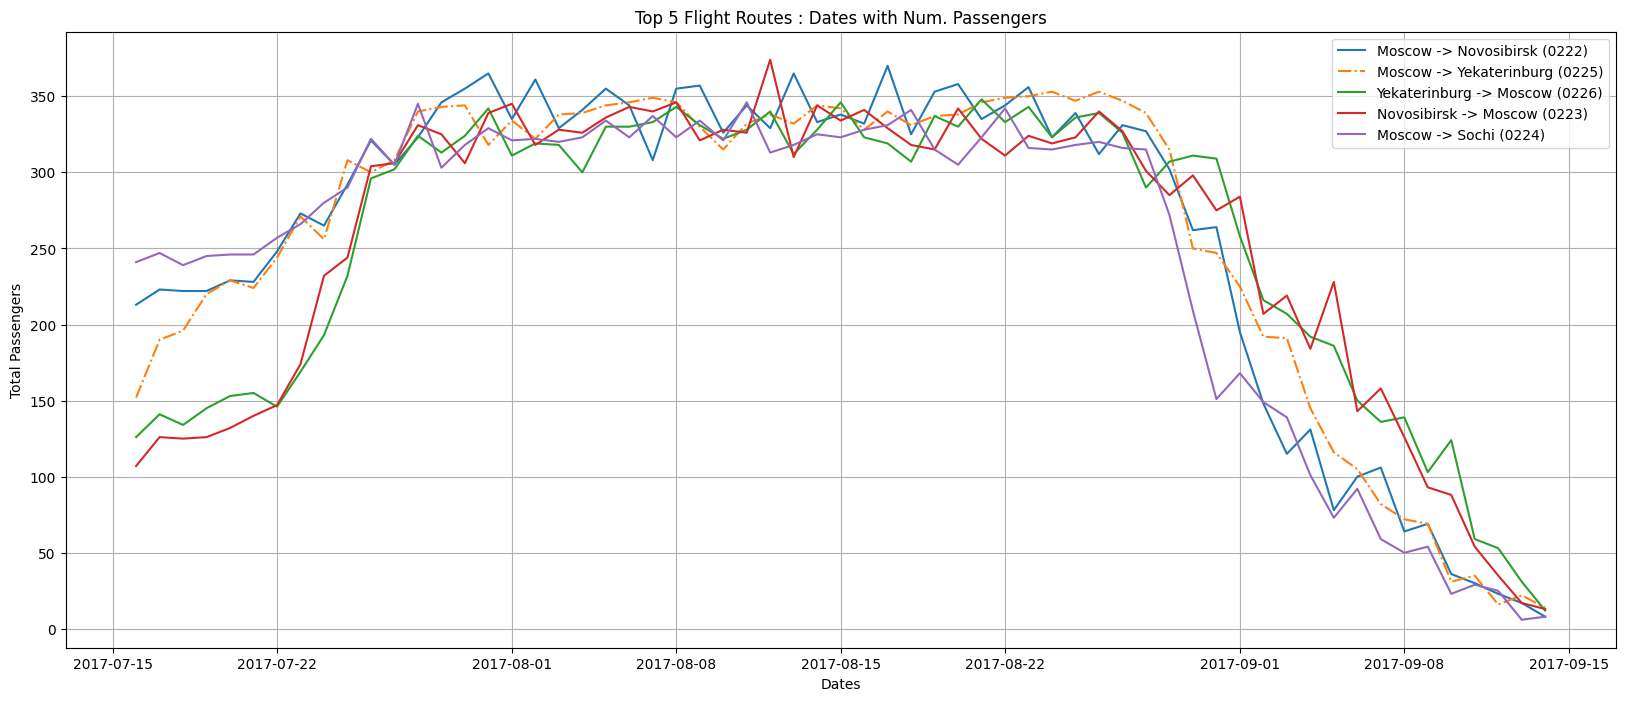

In [151]:
x = mydates
y1 = json['PG0222'] # Moscow -> Novosibirsk
y2 = json['PG0225'] # Moscow -> Yekaterinburg 
y3 = json['PG0226'] # Yekaterinburg -> Moscow
y4 = json['PG0223'] # Novosibirsk -> Moscow
y5 = json['PG0224'] # Moscow -> Sochi


plt.figure(figsize=(20,8))
plt.plot(x, y1, label ='Moscow -> Novosibirsk (0222)')
plt.plot(x, y2, '-.', label ='Moscow -> Yekaterinburg (0225)')
plt.plot(x, y3, label ='Yekaterinburg -> Moscow (0226)')
plt.plot(x, y4, label ='Novosibirsk -> Moscow (0223)')
plt.plot(x, y5, label ='Moscow -> Sochi (0224)')


plt.xlabel("Dates")
plt.ylabel("Total Passengers")
plt.grid()
plt.legend()
plt.title('Top 5 Flight Routes : Dates with Num. Passengers')
plt.show()

# <u><center>Step 4 - Comparing Flight Route and Date<center></u>

### The top 20 busiest flight routes are 

In [138]:
top20[['flight_no','Departure City','Arrival City']]

,flight_no,Departure City,Arrival City
400,PG0222,Moscow,Novosibirsk
64,PG0225,Moscow,Yekaterinburg
251,PG0226,Yekaterinburg,Moscow
218,PG0223,Novosibirsk,Moscow
235,PG0224,Moscow,Sochi
438,PG0013,Sochi,Moscow
60,PG0277,Moscow,Novosibirsk
471,PG0412,Moscow,Perm
248,PG0413,Perm,Moscow
1,PG0278,Novosibirsk,Moscow


### The busiest times to fly are from the last week of July to the last week of August.